# Deel 1 Exploratory data analysis

### Achtergrond

We gaan werken aan het opsporen van Invasief ductaal carcinoom (Invasive ductal carcinoma, IDC). De oorspronkelijke dataset bestond uit 279 scans van borsten met en dergelijk carcicoom. Van deze oorspronkelijke data zijn 277.524 uitsneden gemaakt: 198.738 IDC-negatief and 78.786 IDC positief. Elke patiënt heeft z'n eigen directory die genoemd is naar het patiëntnummer. In deze directories vind je telkens weer twee andere directories: 0 en 1 met hierin de uiteindelijke uitsneden. De namen van al deze plaatjes hebben hetzelfde algemene formaat:

<patiennr>_idx5_<x-coord>_<y_coord>_class[01].png

De uitsneden die in de klasse 0 zitten betreffen gezond weefsel, de uitsneden in de directory 1 bevatten (delen van) tumoren. De bedoeling van deze opdracht is om een netwerk te creëren dat in staat is het gezonde van het ongezonde weefsteld te onderscheiden.

### Laad Libraries 

In [1]:
# Voor mappenbeheer
import os 
# Voor machine learning
import tensorflow as tf 
from sklearn.model_selection import train_test_split
# Voor visualisaties
import matplotlib.pyplot as plt  
# Voor datamanipulatie
import numpy as np  
import shutil
import random
# Voor laden en bewerken van afbeeldingen
from PIL import Image 

### Laad de dataset

We checken eerst het aantal patienten waar we mee werken:

In [2]:
data_path = "../data/idc_regular"
# Controleer aantal patiënten
patient_dirs = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
print(f"Aantal patiënten: {len(patient_dirs)}")

Aantal patiënten: 279


Er zijn inderdaad 279 directories aanwezig. We kiezen eerst 1 patient om de structuur van de data te bekijken. We gebruiken de library PIL met de module Image om RGB afbeeldingen (kleurenafbeeldingen) te openen en zetten het gelijk om in een array:

In [3]:
# Stel patiënt ID in
patient_id = '../data/idc_regular/8863'

# Lijsten voor positieve en negatieve afbeeldingen
imgs_positive = []
imgs_negative = []

# Vul de lijsten met bestanden
imgs_negative.extend(os.listdir(f'{patient_id}/0/'))
imgs_positive.extend(os.listdir(f'{patient_id}/1/'))

# Kies een willekeurige positieve afbeelding
idx = np.random.choice(len(imgs_positive))
img = Image.open(f'{patient_id}/1/{imgs_positive[idx]}') 

# Toon details van de afbeelding
print(img.format)
print(img.size)
print(img.mode)

# Zet afbeelding om naar een numpy-array en toon de vorm
print(np.asarray(img).shape)

PNG
(50, 50)
RGB
(50, 50, 3)


De output is PNG (50, 50) en RGB (50, 50, 3). De eerste twee values zijn hoogte en breedte en de derde input zijn de kleurkanalen. Er staat dus  (50 pixels, 50 pixels, [rood, blauw, groen]). Laaten we voor deze ene patient kijken hoeveel afbeeldingen er in elke map zitten en wat de maximale en minimale pixelwaardes zijn:

In [4]:
# Stel patiënt ID in
patient_id = '../data/idc_regular/8863'  # Specifieke patiëntenmap

# Lijsten voor positieve en negatieve afbeeldingen
imgs_positive = []
imgs_negative = []

# Vul de lijsten met bestanden
imgs_negative.extend(os.listdir(f'{patient_id}/0/'))
imgs_positive.extend(os.listdir(f'{patient_id}/1/'))

# Check hoeveel afbeeldingen er zijn
print(f"Aantal afbeeldingen in map 0 (gezond weefsel): {len(imgs_negative)}")
print(f"Aantal afbeeldingen in map 1 (ongezond weefsel): {len(imgs_positive)}")

# Kies een willekeurige positieve afbeelding en controleer
idx = np.random.choice(len(imgs_positive))
img = Image.open(f'{patient_id}/1/{imgs_positive[idx]}') 

# Zet afbeelding om naar een numpy-array en toon minimale en maximale waarden
img_array = np.asarray(img)
print(f"Minimale pixelwaarde: {np.min(img_array)}")
print(f"Maximale pixelwaarde: {np.max(img_array)}")

Aantal afbeeldingen in map 0 (gezond weefsel): 772
Aantal afbeeldingen in map 1 (ongezond weefsel): 207
Minimale pixelwaarde: 36
Maximale pixelwaarde: 208


Er zit bij patient 8863 significant minder ongezond weefsel dan gezond weefsel. Dit kan misschien een trend zijn voor elke patient. 

### Missende waarden

Sinds de dataset zo groot is, laten we eerst een subset maken:

In [5]:
# Originele dataset path en doel voor subset
original_dataset_path = "../data/idc_regular"
subset_path = "../data/subset_data"

# Parameters voor subset
num_patients = 10  # Aantal patiëntenfolders om te selecteren
num_images_per_class = 50  # Aantal afbeeldingen per klasse (0 en 1)

# Functie om subset te maken
def create_subset(original_path, subset_path, num_patients, num_images_per_class):
    if not os.path.exists(subset_path):
        os.makedirs(subset_path)

    # Selecteer willekeurige patiëntenfolders
    patient_folders = [f for f in os.listdir(original_path) if os.path.isdir(os.path.join(original_path, f))]
    selected_patients = random.sample(patient_folders, min(num_patients, len(patient_folders)))

    for patient in selected_patients:
        patient_original_path = os.path.join(original_path, patient)
        patient_subset_path = os.path.join(subset_path, patient)

        if not os.path.exists(patient_subset_path):
            os.makedirs(patient_subset_path)

        for class_folder in ["0", "1"]:
            class_original_path = os.path.join(patient_original_path, class_folder)
            class_subset_path = os.path.join(patient_subset_path, class_folder)

            if os.path.exists(class_original_path):
                os.makedirs(class_subset_path, exist_ok=True)

                # Selecteer willekeurige afbeeldingen
                images = [f for f in os.listdir(class_original_path) if f.endswith(".png")]
                selected_images = random.sample(images, min(num_images_per_class, len(images)))

                # Kopieer geselecteerde afbeeldingen naar subset
                for image in selected_images:
                    src = os.path.join(class_original_path, image)
                    dst = os.path.join(class_subset_path, image)
                    shutil.copyfile(src, dst)

    print(f"Subset created at: {subset_path}")

# Run de subset generator
create_subset(original_dataset_path, subset_path, num_patients, num_images_per_class)


Subset created at: ../data/subset_data


We gaan nu de missende waarden checken van de dataset:

In [6]:
# Path naar de dataset
dataset_path = "../data/subset_data"  # Of de originele dataset

# Functie om afwijkingen te controleren
def detect_invalid_images_with_shape(dataset_path):
    invalid_images = []  # Hier slaan we alle afwijkende afbeeldingen op

    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".png"):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        # Converteer afbeelding naar een numpy-array
                        img_array = np.array(img)
                        
                        # Controleer vorm
                        if img_array.shape[:2] != (50, 50):
                            invalid_images.append((file_path, f"Invalid shape: {img_array.shape[:2]}"))
                        
                        # Controleer modus (grijswaarden is 'L')
                        if img.mode == 'L':  # Grijswaarden zijn niet toegestaan
                            invalid_images.append((file_path, f"Invalid mode: {img.mode}"))
                except Exception as e:
                    invalid_images.append((file_path, f"Error: {str(e)}"))

    return invalid_images

invalid_images = detect_invalid_images_with_shape(dataset_path)

# Resultaten tonen
if invalid_images:
    print(f"Found {len(invalid_images)} invalid images:")
    for file_path, issue in invalid_images:
        print(f"{file_path}: {issue}")
else:
    print("All images meet the requirements!")


Found 11 invalid images:
../data/subset_data\10302\0\10302_idx5_x2051_y2351_class0.png: Invalid shape: (20, 50)
../data/subset_data\10302\0\10302_idx5_x3101_y901_class0.png: Invalid shape: (50, 22)
../data/subset_data\12948\0\12948_idx5_x2301_y951_class0.png: Invalid shape: (26, 50)
../data/subset_data\16569\0\16569_idx5_x101_y1501_class0.png: Invalid shape: (43, 50)
../data/subset_data\16569\0\16569_idx5_x351_y1501_class0.png: Invalid shape: (43, 50)
../data/subset_data\16569\0\16569_idx5_x401_y1501_class0.png: Invalid shape: (43, 50)
../data/subset_data\16569\0\16569_idx5_x51_y1501_class0.png: Invalid shape: (43, 50)
../data/subset_data\16569\0\16569_idx5_x601_y1501_class0.png: Invalid shape: (43, 50)
../data/subset_data\16569\0\16569_idx5_x751_y1501_class0.png: Invalid shape: (43, 50)
../data/subset_data\16569\0\16569_idx5_x851_y1501_class0.png: Invalid shape: (43, 50)
../data/subset_data\9262\1\9262_idx5_x501_y1701_class1.png: Invalid shape: (44, 50)


Er zijn dus images die niet voldoen aan de waarde van 50 bij 50 pixels. Deze moeten verwijderd worden in de uiteindelijke subset die gebruikt wordt voor het model. 

In [7]:
# Path naar de dataset
dataset_path = "../data/subset_data"  

# Functie om ongeldige afbeeldingen te detecteren en te verwijderen
def remove_invalid_images(dataset_path):
    removed_images = []  # Lijst met paden van verwijderde afbeeldingen
    errors = []  # Lijst met afbeeldingen die niet verwijderd konden worden

    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".png"):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        # Converteer afbeelding naar een numpy-array
                        img_array = np.array(img)

                        # Controleer of de afbeelding ongeldig is
                        if img_array.shape[:2] != (50, 50) or img.mode == 'L':
                            # Verwijder de afbeelding
                            os.remove(file_path)
                            removed_images.append(file_path)
                except Exception as e:
                    errors.append((file_path, str(e)))

    return removed_images, errors

# Run de controle en verwijdering
removed_images, errors = remove_invalid_images(dataset_path)

# Resultaten tonen
if removed_images:
    print(f"Removed {len(removed_images)} invalid images:")
    for file_path in removed_images:
        print(f"Removed: {file_path}")
else:
    print("No invalid images found!")

if errors:
    print(f"Encountered {len(errors)} errors while trying to remove images:")
    for file_path, error in errors:
        print(f"{file_path}: {error}")


Removed 11 invalid images:
Removed: ../data/subset_data\10302\0\10302_idx5_x2051_y2351_class0.png
Removed: ../data/subset_data\10302\0\10302_idx5_x3101_y901_class0.png
Removed: ../data/subset_data\12948\0\12948_idx5_x2301_y951_class0.png
Removed: ../data/subset_data\16569\0\16569_idx5_x101_y1501_class0.png
Removed: ../data/subset_data\16569\0\16569_idx5_x351_y1501_class0.png
Removed: ../data/subset_data\16569\0\16569_idx5_x401_y1501_class0.png
Removed: ../data/subset_data\16569\0\16569_idx5_x51_y1501_class0.png
Removed: ../data/subset_data\16569\0\16569_idx5_x601_y1501_class0.png
Removed: ../data/subset_data\16569\0\16569_idx5_x751_y1501_class0.png
Removed: ../data/subset_data\16569\0\16569_idx5_x851_y1501_class0.png
Removed: ../data/subset_data\9262\1\9262_idx5_x501_y1701_class1.png


De subset_data is nu opgeschoond. 

### Verhouding gezonde en ongezonde weefsels

De breakdown tussen gezonde en ongezonde weefsels gaat ons helpen om beslissingen te maken hoe we de training data gaan splitsen. 

In [8]:
# hoofdmap
patient_id = '../data/idc_regular/'

# Lijsten voor positieve en negatieve afbeeldingen
imgs_positive = []
imgs_negative = []

# Loop door alle subdirectories in 'idc_regular'
for subdir in os.listdir(patient_id):
    subdir_path = os.path.join(patient_id, subdir)
    # Controleer of het een directory is
    if os.path.isdir(subdir_path):
        # Voeg bestanden toe aan de juiste lijst
        try:
            imgs_negative.extend([os.path.join(subdir_path, '0', file) 
                                  for file in os.listdir(os.path.join(subdir_path, '0'))])
            imgs_positive.extend([os.path.join(subdir_path, '1', file) 
                                  for file in os.listdir(os.path.join(subdir_path, '1'))])
        except FileNotFoundError:
            # Sla over als de subdirectory geen '0' of '1' bevat
            pass

# Controleer het aantal afbeeldingen
total_negative = len(imgs_negative)
total_positive = len(imgs_positive)

# Bereken de verhouding
ratio = total_negative / total_positive if total_positive > 0 else "Onbepaald"

# Toon de resultaten
print(f"Totaal aantal gezonde afbeeldingen: {total_negative}")
print(f"Totaal aantal ongezonde afbeeldingen: {total_positive}")
print(f"Verhouding gezonde tot ongezonde afbeeldingen: {ratio:.2f}:1" if total_positive > 0 else "Geen ongezonde afbeeldingen")
print(f"Percentage ongezonde afbeeldingen: {total_positive / (total_negative + total_positive) * 100:.2f}%" if total_positive > 0 else "0.00%")
print(f"Percentage gezonde afbeeldingen: {total_negative / (total_negative + total_positive) * 100:.2f}%" if total_positive > 0 else "100.00%")


Totaal aantal gezonde afbeeldingen: 198738
Totaal aantal ongezonde afbeeldingen: 78786
Verhouding gezonde tot ongezonde afbeeldingen: 2.52:1
Percentage ongezonde afbeeldingen: 28.39%
Percentage gezonde afbeeldingen: 71.61%


We zien hier dat we significant meer gezond weefsel hebben dan ongezond weefsel. Voor elke afbeelding van ongezond weefsel hebben we 2.52 afbeeldingen van gezond weefsel. De dataset bestaat voor 28.39% uit ongezond weefsel en voor 71.61% uit gezond weefsel.

### Ongezond weefsel per patient tov gemiddelde

Dan laten we nu de weefselpercentages zien van de scan, maar nu per patient en ten opzichte van het gemiddelde. 

In [9]:
# Pad naar de hoofdmap
patient_id = '../data/idc_regular/'

# Lijsten voor positieve en negatieve afbeeldingen
patient_data = {}

# Loop door alle subdirectories in 'idc_regular'
for subdir in os.listdir(patient_id):
    subdir_path = os.path.join(patient_id, subdir)
    # Controleer of het een directory is
    if os.path.isdir(subdir_path):
        try:
            # Haal positieve en negatieve afbeeldingen op
            imgs_negative = [os.path.join(subdir_path, '0', file) 
                             for file in os.listdir(os.path.join(subdir_path, '0'))]
            imgs_positive = [os.path.join(subdir_path, '1', file) 
                             for file in os.listdir(os.path.join(subdir_path, '1'))]

            # Bereken aantallen en percentage
            total_negative = len(imgs_negative)
            total_positive = len(imgs_positive)
            total_images = total_negative + total_positive
            percentage_positive = (total_positive / total_images * 100) if total_images > 0 else 0

            # Voeg data toe aan patient_data
            patient_data[subdir] = {
                "total_negative": total_negative,
                "total_positive": total_positive,
                "percentage_positive": percentage_positive
            }
        except FileNotFoundError:
            # Sla over als de subdirectory geen '0' of '1' bevat
            pass

# Bereken gemiddelde percentage ongezonde afbeeldingen
all_positive = sum(data["total_positive"] for data in patient_data.values())
all_images = sum(data["total_negative"] + data["total_positive"] for data in patient_data.values())
average_positive_percentage = (all_positive / all_images * 100) if all_images > 0 else 0

# Toon resultaten per patiënt
print("Resultaten per patiënt:")
for patient, data in patient_data.items():
    print(f"Patiënt: {patient}")
    print(f"  Totaal gezonde afbeeldingen: {data['total_negative']}")
    print(f"  Totaal ongezonde afbeeldingen: {data['total_positive']}")
    print(f"  Percentage ongezonde afbeeldingen: {data['percentage_positive']:.2f}%")
    comparison = "boven" if data['percentage_positive'] > average_positive_percentage else "onder"
    print(f"  Dit percentage is {comparison} het gemiddelde ({average_positive_percentage:.2f}%).")

# Toon algemene resultaten
print("\nAlgemene resultaten:")
print(f"Totaal aantal afbeeldingen: {all_images}")
print(f"Totaal ongezonde afbeeldingen: {all_positive}")
print(f"Gemiddelde percentage ongezonde afbeeldingen: {average_positive_percentage:.2f}%")


Resultaten per patiënt:
Patiënt: 10253
  Totaal gezonde afbeeldingen: 479
  Totaal ongezonde afbeeldingen: 70
  Percentage ongezonde afbeeldingen: 12.75%
  Dit percentage is onder het gemiddelde (28.39%).
Patiënt: 10254
  Totaal gezonde afbeeldingen: 772
  Totaal ongezonde afbeeldingen: 76
  Percentage ongezonde afbeeldingen: 8.96%
  Dit percentage is onder het gemiddelde (28.39%).
Patiënt: 10255
  Totaal gezonde afbeeldingen: 181
  Totaal ongezonde afbeeldingen: 91
  Percentage ongezonde afbeeldingen: 33.46%
  Dit percentage is boven het gemiddelde (28.39%).
Patiënt: 10256
  Totaal gezonde afbeeldingen: 351
  Totaal ongezonde afbeeldingen: 117
  Percentage ongezonde afbeeldingen: 25.00%
  Dit percentage is onder het gemiddelde (28.39%).
Patiënt: 10257
  Totaal gezonde afbeeldingen: 427
  Totaal ongezonde afbeeldingen: 208
  Percentage ongezonde afbeeldingen: 32.76%
  Dit percentage is boven het gemiddelde (28.39%).
Patiënt: 10258
  Totaal gezonde afbeeldingen: 422
  Totaal ongezonde a

We zien dat verschillende patienten verschillende mate van tumorgroei hebben in hun weefsel. Het gemiddelde van ongezonde afbeeldingen is 28.39%. We kunnen zien welke gebieden van de totale scan (x-y-coördinaten) het meest worden geïnfecteerd met IDC. Op basis van dit gegeven kunnen we iets zeggen dat tumoren op elke plek in de scan voor kunnen komen. Dit is echter al voor de hand liggend, dus gaan we verder naar de visualisaties:

### Visualisaties

We tonen nu een aantal uitsneden van zowel gezond als ongezond weefsel:

cancerous:


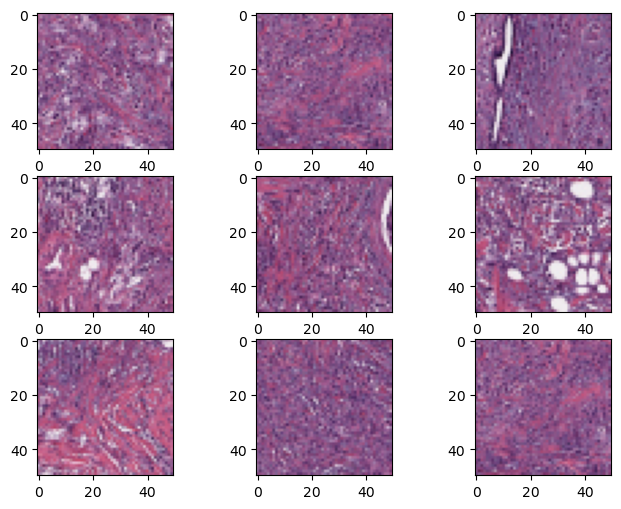

healthy:


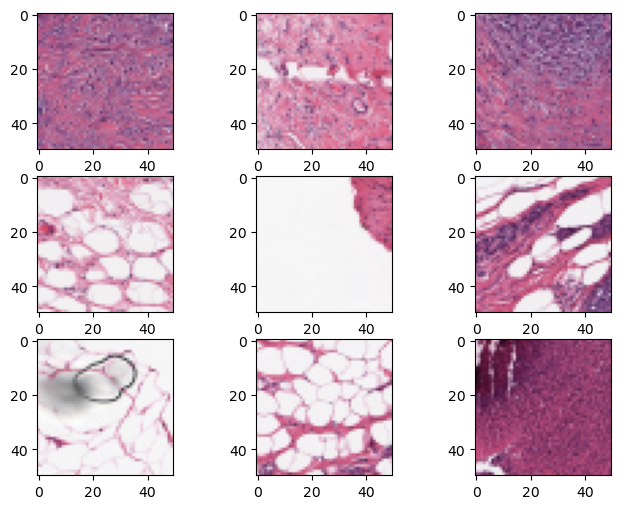

In [10]:
# Stel patiënt ID in
patient_id = '../data/idc_regular/8863'

# Lijsten voor positieve en negatieve afbeeldingen
imgs_positive = []
imgs_negative = []

# Vul de lijsten met bestanden
imgs_negative.extend(os.listdir(f'{patient_id}/0/'))
imgs_positive.extend(os.listdir(f'{patient_id}/1/'))

# Kies een willekeurige positieve afbeelding
idx = np.random.choice(len(imgs_positive))
img = Image.open(f'{patient_id}/1/{imgs_positive[idx]}') 

# Plot 3x3 positieve afbeeldingen (directory 1)
fig, ax = plt.subplots(3, 3, figsize=(8, 6))
for r in range(3):
    for c in range(3):
        idx = np.random.choice(len(imgs_positive))
        img = Image.open(f'{patient_id}/1/{imgs_positive[idx]}')
        ax[c, r].imshow(img, cmap='gray')
print("cancerous:")
plt.show()

# Plot 3x3 negatieve afbeeldingen (directory 0)
fig, ax = plt.subplots(3, 3, figsize=(8, 6))
for r in range(3):
    for c in range(3):
        idx = np.random.choice(len(imgs_negative))
        img = Image.open(f'{patient_id}/0/{imgs_negative[idx]}')
        ax[c, r].imshow(img, cmap='gray')
print("healthy:")
plt.show()

Bij het bekijken van weefselafbeeldingen valt op dat kankercellen doorgaans een intensere paarse kleur hebben, veroorzaakt door een hogere kernendichtheid (donkerpaarse kleuring door hematoxyline). Gezond weefsel bevat meer witte gebieden door extracellulaire ruimtes of vetweefsel en heeft een meer georganiseerde structuur. Deze kleurverschillen zijn nuttig voor classificatie tussen kankercellen en gezond weefsel. Dit klopt met de literatuur. 

# Deel 2 Een model trainen

### Preprocess de data

Eerst moeten we de data splitten. Je kunt de data splitsen op twee manieren:

- Horizontaal (per patiënt een deel weghalen)
    Hierbij splits je de afbeeldingen binnen dezelfde patiënt in trainings- en testsets.
    Afbeeldingen uit elke patiëntmap willekeurig worden verdeeld tussen de train- en testsets.
    Voordeel: Meer data beschikbaar in beide sets, maar kan leiden tot overfitting als patiëntenvariatie niet goed wordt meegenomen.
- Verticaal (een deel van de patiënten als testset)
    Hierbij splits je de patiënten zelf in trainings- en testsets.
    Hele patiëntmappen toewijzen aan de train- of testset
    Voordeel: Realistischere evaluatie, omdat het model leert generaliseren naar nieuwe patiënten.

De onderstaande code implementeert een horizontale splitsing. Het doel is om het model te laten leren op basis van kenmerken die aanwezig zijn in individuele uitsneden (bijvoorbeeld textuur of kleurverandering), dan is horizontale splitsing logisch. Het model leert dan patronen herkennen die indicatief zijn voor IDC, onafhankelijk van de patiënt. Als het doel is om niet patiënten te classificeren, maar uitsneden (bijvoorbeeld voor specifieke onderzoeken naar micro-locaties in weefsel), dan past horizontale splitsing beter bij deze vraagstelling.

In [52]:
# Het datapad is nog steeds "..data/subset_data"
def collect_images(patient_paths):
    images, labels = [], []
    for patient_path in patient_paths:
        for label in ['0', '1']:
            folder_path = os.path.join(patient_path, label)
            if os.path.exists(folder_path):
                for file in os.listdir(folder_path):
                    file_path = os.path.join(folder_path, file)
                    img = Image.open(file_path)
                    images.append(np.array(img))  # Afbeelding opslaan als numpy array
                    labels.append(int(label))  # Label is 0 (gezond) of 1 (ongezond)
    return images, labels

# Verzamelen van alle patiëntmappen
patient_folders = [os.path.join(dataset_path, subdir) for subdir in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, subdir))]

# Splits patiënten in train- en testgroepen
train_patients, test_patients = train_test_split(patient_folders, test_size=0.2, random_state=42)

# Verzamel afbeeldingen en labels voor train- en testgroepen
train_images, train_labels = collect_images(train_patients)
test_images, test_labels = collect_images(test_patients)

# Inspectie van de vorm van afbeeldingen
print(f"Train images shape: {np.array(train_images).shape}")
print(f"Test images shape: {np.array(test_images).shape}")

# Gezonde (label 0) en ongezonde (label 1) foto's tellen
num_train_healthy = sum(label == 0 for label in train_labels)
num_train_unhealthy = sum(label == 1 for label in train_labels)

num_test_healthy = sum(label == 0 for label in test_labels)
num_test_unhealthy = sum(label == 1 for label in test_labels)

# Resultaten tonen
print(f"Train healthy images: {num_train_healthy}, Train unhealthy images: {num_train_unhealthy}")
print(f"Test healthy images: {num_test_healthy}, Test unhealthy images: {num_test_unhealthy}")
test_images


Train images shape: (5895, 50, 50, 3)
Test images shape: (1519, 50, 50, 3)
Train healthy images: 3024, Train unhealthy images: 2871
Test healthy images: 816, Test unhealthy images: 703


[array([[[244, 238, 241],
         [244, 242, 245],
         [236, 206, 224],
         ...,
         [228, 185, 211],
         [229, 187, 213],
         [233, 204, 224]],
 
        [[245, 243, 245],
         [248, 240, 244],
         [234, 188, 212],
         ...,
         [241, 235, 243],
         [245, 239, 242],
         [237, 220, 228]],
 
        [[245, 241, 244],
         [244, 236, 240],
         [237, 194, 213],
         ...,
         [242, 236, 236],
         [236, 230, 237],
         [237, 221, 232]],
 
        ...,
 
        [[244, 245, 244],
         [244, 242, 244],
         [245, 242, 246],
         ...,
         [224, 155, 195],
         [232, 169, 203],
         [225, 149, 193]],
 
        [[245, 244, 242],
         [244, 228, 237],
         [245, 241, 247],
         ...,
         [222, 148, 188],
         [227, 150, 193],
         [220, 140, 185]],
 
        [[245, 232, 244],
         [238, 223, 233],
         [226, 188, 212],
         ...,
         [184, 126, 174],
  

We werken voor nu dus met een training data waarvan de verdeling te zien is in het bovenstaande codeblock (aantal images, pixel 1, pixel 2, RGB waarde). Alle images zijn 50x50 pixels en hebben een RGB waarde die 3 is (rood, blauw groen). Hieronder zijn de pixel values te zien:

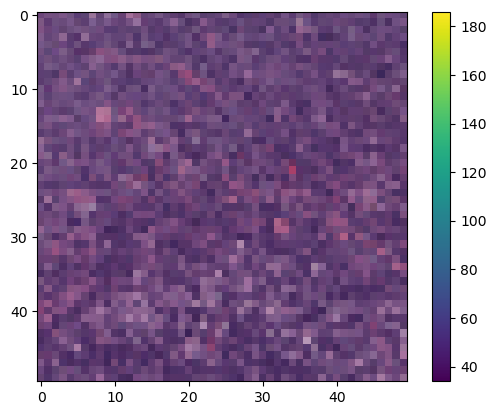

Minimale pixelvalue: 34
Maximale pixelvalue: 186


In [12]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

print(f"Minimale pixelvalue: {np.min(train_images[0])}")
print(f"Maximale pixelvalue: {np.max(train_images[0])}")

De maximale pixelvalue van deze specifieke afbeelding is dus 247. We moeten deze schaalen naar een getal van 0 tot 1. We delen de pixelvalues door 255 omdat dit de maximale waarde is voor een min-max normalisatie. 

In [60]:
# Zet de lijsten om naar numpy-arrays
train_images = np.array(train_images)
test_images = np.array(test_images)

# Normaliseer de waarden van 0 tot 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# Controleer de vorm en het bereik van de afbeeldingen
print(f"Train images normalized shape: {train_images.shape}, range: {train_images.min()} - {train_images.max()}")
print(f"Test images normalized shape: {test_images.shape}, range: {test_images.min()} - {test_images.max()}")

# Convert labels naar een 1D array
train_labels = np.array(train_labels).reshape(-1, 1)

print(f"Train labels shape after reshaping: {train_labels.shape}")
print(f"train images shape: {train_images.shape}")

Train images normalized shape: (5895, 50, 50, 3), range: 1.091139234430393e-14 - 9.274683492658337e-13
Test images normalized shape: (1519, 50, 50, 3), range: 1.091139234430393e-14 - 9.23831218484399e-13
Train labels shape after reshaping: (5895, 1)
train images shape: (5895, 50, 50, 3)


Om te verivieren dat de data in het juiste format staat gaan we eerst checken:

### Modeltraining

In [42]:
# Create a simple model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(50, 50, 3)),  # Input shape should match your image data
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification output
])

c:\Users\isabe\anaconda3\envs\modelleren_van_kanker\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile model

In [43]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [59]:
print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {np.array(train_labels).shape}")

Train images shape: (5895, 50, 50, 3)
Train labels shape: (5895, 1)


### Fit de data

In [47]:
# Fit the model
history = model.fit(
    train_images, 
    train_labels, 
    epochs=10,  # Adjust epochs as needed
    validation_data=(test_images, test_labels)
)


Epoch 1/10
183/185 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5149 - loss: 0.6930

ValueError: Unrecognized data type: x=[[[[8.87459911e-13 8.65637126e-13 8.76548518e-13]
   [8.87459911e-13 8.80185649e-13 8.91097041e-13]
   [8.58362864e-13 7.49248941e-13 8.14717295e-13]
   ...
   [8.29265818e-13 6.72869195e-13 7.67434595e-13]
   [8.32902949e-13 6.80143456e-13 7.74708856e-13]
   [8.47451472e-13 7.41974679e-13 8.14717295e-13]]

  [[8.91097041e-13 8.83822780e-13 8.91097041e-13]
   [9.02008434e-13 8.72911388e-13 8.87459911e-13]
   [8.51088603e-13 6.83780587e-13 7.71071726e-13]
   ...
   [8.76548518e-13 8.54725734e-13 8.83822780e-13]
   [8.91097041e-13 8.69274257e-13 8.80185649e-13]
   [8.61999995e-13 8.00168772e-13 8.29265818e-13]]

  [[8.91097041e-13 8.76548518e-13 8.87459911e-13]
   [8.87459911e-13 8.58362864e-13 8.72911388e-13]
   [8.61999995e-13 7.05603372e-13 7.74708856e-13]
   ...
   [8.80185649e-13 8.58362864e-13 8.58362864e-13]
   [8.58362864e-13 8.36540080e-13 8.61999995e-13]
   [8.61999995e-13 8.03805903e-13 8.43814341e-13]]

  ...

  [[8.87459911e-13 8.91097041e-13 8.87459911e-13]
   [8.87459911e-13 8.80185649e-13 8.87459911e-13]
   [8.91097041e-13 8.80185649e-13 8.94734172e-13]
   ...
   [8.14717295e-13 5.63755271e-13 7.09240502e-13]
   [8.43814341e-13 6.14675102e-13 7.38337549e-13]
   [8.18354426e-13 5.41932486e-13 7.01966241e-13]]

  [[8.91097041e-13 8.87459911e-13 8.80185649e-13]
   [8.87459911e-13 8.29265818e-13 8.61999995e-13]
   [8.91097041e-13 8.76548518e-13 8.98371303e-13]
   ...
   [8.07443033e-13 5.38295356e-13 6.83780587e-13]
   [8.25628687e-13 5.45569617e-13 7.01966241e-13]
   [8.00168772e-13 5.09198309e-13 6.72869195e-13]]

  [[8.91097041e-13 8.43814341e-13 8.87459911e-13]
   [8.65637126e-13 8.11080164e-13 8.47451472e-13]
   [8.21991557e-13 6.83780587e-13 7.71071726e-13]
   ...
   [6.69232064e-13 4.58278478e-13 6.32860756e-13]
   [7.74708856e-13 5.89215187e-13 7.09240502e-13]
   [8.36540080e-13 6.25586494e-13 7.31063287e-13]]]


 [[[5.60118140e-13 2.90970463e-13 4.98286917e-13]
   [7.27426156e-13 4.10995778e-13 5.81940925e-13]
   [7.71071726e-13 3.27341770e-13 5.31021094e-13]
   ...
   [8.87459911e-13 8.76548518e-13 8.80185649e-13]
   [8.51088603e-13 7.41974679e-13 8.00168772e-13]
   [8.18354426e-13 6.14675102e-13 7.20151895e-13]]

  [[6.51046410e-13 4.43729955e-13 6.11037971e-13]
   [6.32860756e-13 3.85535863e-13 5.85578056e-13]
   [7.60160333e-13 3.89172994e-13 5.74666663e-13]
   ...
   [8.91097041e-13 8.80185649e-13 8.83822780e-13]
   [8.98371303e-13 8.76548518e-13 8.83822780e-13]
   [8.61999995e-13 7.81983118e-13 8.32902949e-13]]

  [[7.56523203e-13 3.85535863e-13 5.67392402e-13]
   [7.12877633e-13 3.96447255e-13 5.89215187e-13]
   [7.16514764e-13 3.96447255e-13 5.81940925e-13]
   ...
   [8.83822780e-13 8.69274257e-13 8.94734172e-13]
   [8.83822780e-13 8.80185649e-13 8.87459911e-13]
   [8.80185649e-13 8.80185649e-13 8.72911388e-13]]

  ...

  [[7.31063287e-13 3.05518986e-13 5.01924048e-13]
   [7.38337549e-13 3.85535863e-13 5.67392402e-13]
   [7.52886072e-13 3.70987340e-13 5.49206748e-13]
   ...
   [8.87459911e-13 8.76548518e-13 8.83822780e-13]
   [8.87459911e-13 8.76548518e-13 8.83822780e-13]
   [8.87459911e-13 8.76548518e-13 8.83822780e-13]]

  [[6.94691979e-13 3.52801686e-13 5.31021094e-13]
   [7.27426156e-13 2.83696201e-13 4.87375525e-13]
   [6.54683541e-13 2.65510547e-13 4.83738394e-13]
   ...
   [8.87459911e-13 8.76548518e-13 8.83822780e-13]
   [8.87459911e-13 8.76548518e-13 8.80185649e-13]
   [8.87459911e-13 8.76548518e-13 8.83822780e-13]]

  [[7.96531641e-13 6.91054848e-13 7.71071726e-13]
   [7.52886072e-13 4.51004217e-13 6.11037971e-13]
   [7.38337549e-13 3.45527424e-13 5.09198309e-13]
   ...
   [8.83822780e-13 8.76548518e-13 8.80185649e-13]
   [8.83822780e-13 8.76548518e-13 8.80185649e-13]
   [8.87459911e-13 8.76548518e-13 8.80185649e-13]]]


 [[[7.78345987e-13 4.32818563e-13 6.07400840e-13]
   [7.74708856e-13 4.07358648e-13 5.74666663e-13]
   [7.81983118e-13 4.10995778e-13 5.67392402e-13]
   ...
   [7.81983118e-13 4.65552740e-13 6.18312233e-13]
   [7.81983118e-13 3.70987340e-13 5.56481010e-13]
   [7.63797464e-13 3.70987340e-13 5.63755271e-13]]

  [[6.80143456e-13 3.89172994e-13 5.85578056e-13]
   [6.21949364e-13 3.38253163e-13 5.34658225e-13]
   [7.52886072e-13 4.03721517e-13 5.74666663e-13]
   ...
   [6.65594933e-13 4.87375525e-13 6.51046410e-13]
   [7.89257380e-13 4.72827002e-13 6.21949364e-13]
   [7.71071726e-13 4.65552740e-13 6.18312233e-13]]

  [[7.16514764e-13 3.74624470e-13 5.52843879e-13]
   [6.94691979e-13 4.00084386e-13 5.92852317e-13]
   [7.20151895e-13 4.00084386e-13 5.81940925e-13]
   ...
   [7.71071726e-13 4.51004217e-13 6.21949364e-13]
   [7.52886072e-13 3.45527424e-13 5.31021094e-13]
   [7.74708856e-13 3.85535863e-13 5.52843879e-13]]

  ...

  [[7.31063287e-13 4.07358648e-13 5.96489448e-13]
   [6.91054848e-13 4.07358648e-13 5.74666663e-13]
   [7.67434595e-13 4.54641348e-13 6.32860756e-13]
   ...
   [6.58320671e-13 3.52801686e-13 5.52843879e-13]
   [6.91054848e-13 3.60075947e-13 5.71029533e-13]
   [5.45569617e-13 2.87333332e-13 4.94649786e-13]]

  [[7.09240502e-13 4.51004217e-13 6.14675102e-13]
   [7.49248941e-13 5.23746833e-13 6.72869195e-13]
   [7.56523203e-13 4.32818563e-13 6.03763710e-13]
   ...
   [7.56523203e-13 3.96447255e-13 5.78303794e-13]
   [7.63797464e-13 4.83738394e-13 6.32860756e-13]
   [7.85620249e-13 5.12835440e-13 6.51046410e-13]]

  [[7.31063287e-13 4.65552740e-13 6.32860756e-13]
   [7.56523203e-13 3.85535863e-13 5.63755271e-13]
   [7.52886072e-13 3.96447255e-13 5.89215187e-13]
   ...
   [6.72869195e-13 3.67350209e-13 5.56481010e-13]
   [6.03763710e-13 4.00084386e-13 5.92852317e-13]
   [8.11080164e-13 6.00126579e-13 7.27426156e-13]]]


 ...


 [[[6.83780587e-13 4.76464132e-13 6.18312233e-13]
   [7.41974679e-13 5.20109702e-13 6.61957802e-13]
   [6.94691979e-13 4.65552740e-13 6.18312233e-13]
   ...
   [7.12877633e-13 4.91012655e-13 6.43772148e-13]
   [7.23789026e-13 4.76464132e-13 6.32860756e-13]
   [7.23789026e-13 4.54641348e-13 6.11037971e-13]]

  [[6.87417718e-13 4.76464132e-13 6.18312233e-13]
   [5.85578056e-13 4.21907171e-13 5.78303794e-13]
   [6.51046410e-13 4.25544301e-13 6.03763710e-13]
   ...
   [7.16514764e-13 4.87375525e-13 6.18312233e-13]
   [6.47409279e-13 4.65552740e-13 6.29223625e-13]
   [7.63797464e-13 4.47367086e-13 6.18312233e-13]]

  [[6.18312233e-13 4.51004217e-13 6.03763710e-13]
   [7.01966241e-13 4.87375525e-13 6.32860756e-13]
   [7.38337549e-13 4.69189871e-13 6.29223625e-13]
   ...
   [6.11037971e-13 4.47367086e-13 6.14675102e-13]
   [6.80143456e-13 5.05561179e-13 6.43772148e-13]
   [6.32860756e-13 4.69189871e-13 6.11037971e-13]]

  ...

  [[6.00126579e-13 3.74624470e-13 5.63755271e-13]
   [5.23746833e-13 3.27341770e-13 5.12835440e-13]
   [5.71029533e-13 3.81898732e-13 5.78303794e-13]
   ...
   [3.67350209e-13 2.69147678e-13 4.47367086e-13]
   [5.27383963e-13 3.92810124e-13 5.67392402e-13]
   [4.69189871e-13 3.38253163e-13 5.20109702e-13]]

  [[6.18312233e-13 4.69189871e-13 6.11037971e-13]
   [7.09240502e-13 5.85578056e-13 6.69232064e-13]
   [7.81983118e-13 6.80143456e-13 7.41974679e-13]
   ...
   [4.58278478e-13 3.09156116e-13 4.98286917e-13]
   [4.76464132e-13 3.52801686e-13 5.31021094e-13]
   [5.60118140e-13 3.92810124e-13 5.71029533e-13]]

  [[4.91012655e-13 3.52801686e-13 5.31021094e-13]
   [4.98286917e-13 3.41890293e-13 5.23746833e-13]
   [6.00126579e-13 4.58278478e-13 5.89215187e-13]
   ...
   [4.94649786e-13 3.56438817e-13 5.27383963e-13]
   [5.67392402e-13 3.92810124e-13 5.81940925e-13]
   [5.05561179e-13 3.60075947e-13 5.52843879e-13]]]


 [[[7.56523203e-13 6.91054848e-13 7.71071726e-13]
   [8.65637126e-13 8.58362864e-13 8.51088603e-13]
   [8.69274257e-13 8.51088603e-13 8.65637126e-13]
   ...
   [7.63797464e-13 5.38295356e-13 6.47409279e-13]
   [7.71071726e-13 4.69189871e-13 6.21949364e-13]
   [8.18354426e-13 5.60118140e-13 6.83780587e-13]]

  [[6.07400840e-13 4.36455694e-13 5.85578056e-13]
   [8.47451472e-13 8.03805903e-13 8.43814341e-13]
   [8.69274257e-13 8.40177211e-13 8.51088603e-13]
   ...
   [7.71071726e-13 5.41932486e-13 6.76506325e-13]
   [7.56523203e-13 4.80101263e-13 6.21949364e-13]
   [7.71071726e-13 4.98286917e-13 6.29223625e-13]]

  [[7.12877633e-13 5.92852317e-13 6.91054848e-13]
   [6.40135018e-13 5.52843879e-13 6.72869195e-13]
   [8.14717295e-13 7.81983118e-13 8.21991557e-13]
   ...
   [7.56523203e-13 5.52843879e-13 6.72869195e-13]
   [7.71071726e-13 6.03763710e-13 7.09240502e-13]
   [8.03805903e-13 6.58320671e-13 7.31063287e-13]]

  ...

  [[7.20151895e-13 5.34658225e-13 6.72869195e-13]
   [5.71029533e-13 3.74624470e-13 5.71029533e-13]
   [5.16472571e-13 3.63713078e-13 5.31021094e-13]
   ...
   [7.31063287e-13 5.52843879e-13 6.83780587e-13]
   [7.20151895e-13 5.49206748e-13 6.83780587e-13]
   [6.61957802e-13 4.32818563e-13 5.96489448e-13]]

  [[6.25586494e-13 4.36455694e-13 6.07400840e-13]
   [4.03721517e-13 2.76421939e-13 4.65552740e-13]
   [5.12835440e-13 3.60075947e-13 5.27383963e-13]
   ...
   [5.92852317e-13 4.07358648e-13 5.78303794e-13]
   [6.91054848e-13 4.65552740e-13 6.29223625e-13]
   [6.14675102e-13 3.96447255e-13 5.81940925e-13]]

  [[5.60118140e-13 3.85535863e-13 5.41932486e-13]
   [6.51046410e-13 4.65552740e-13 6.11037971e-13]
   [6.94691979e-13 4.51004217e-13 6.18312233e-13]
   ...
   [4.36455694e-13 2.87333332e-13 4.80101263e-13]
   [5.85578056e-13 3.74624470e-13 5.60118140e-13]
   [5.60118140e-13 3.85535863e-13 5.78303794e-13]]]


 [[[6.14675102e-13 4.29181432e-13 6.03763710e-13]
   [7.01966241e-13 5.78303794e-13 6.91054848e-13]
   [6.65594933e-13 5.31021094e-13 6.61957802e-13]
   ...
   [6.51046410e-13 4.43729955e-13 6.11037971e-13]
   [6.83780587e-13 4.80101263e-13 6.36497887e-13]
   [6.87417718e-13 5.45569617e-13 6.76506325e-13]]

  [[6.80143456e-13 4.98286917e-13 6.54683541e-13]
   [7.85620249e-13 7.49248941e-13 7.92894510e-13]
   [7.74708856e-13 7.20151895e-13 7.89257380e-13]
   ...
   [6.94691979e-13 5.41932486e-13 6.76506325e-13]
   [6.76506325e-13 4.94649786e-13 6.51046410e-13]
   [6.83780587e-13 5.45569617e-13 6.69232064e-13]]

  [[8.11080164e-13 7.60160333e-13 7.96531641e-13]
   [8.54725734e-13 8.25628687e-13 8.43814341e-13]
   [7.27426156e-13 6.43772148e-13 7.49248941e-13]
   ...
   [6.80143456e-13 5.38295356e-13 6.72869195e-13]
   [6.83780587e-13 5.27383963e-13 6.61957802e-13]
   [6.76506325e-13 5.27383963e-13 6.69232064e-13]]

  ...

  [[6.65594933e-13 4.14632909e-13 5.85578056e-13]
   [6.83780587e-13 4.87375525e-13 6.32860756e-13]
   [6.51046410e-13 4.36455694e-13 6.32860756e-13]
   ...
   [6.47409279e-13 4.14632909e-13 5.81940925e-13]
   [6.61957802e-13 4.91012655e-13 6.40135018e-13]
   [7.20151895e-13 5.52843879e-13 6.80143456e-13]]

  [[6.76506325e-13 4.98286917e-13 6.47409279e-13]
   [6.51046410e-13 4.69189871e-13 6.36497887e-13]
   [5.12835440e-13 3.23704640e-13 5.16472571e-13]
   ...
   [6.61957802e-13 4.58278478e-13 6.14675102e-13]
   [4.94649786e-13 3.45527424e-13 5.23746833e-13]
   [6.21949364e-13 4.58278478e-13 6.07400840e-13]]

  [[7.05603372e-13 4.51004217e-13 6.21949364e-13]
   [5.16472571e-13 3.92810124e-13 5.63755271e-13]
   [4.94649786e-13 3.30978901e-13 5.16472571e-13]
   ...
   [4.91012655e-13 3.38253163e-13 5.09198309e-13]
   [6.51046410e-13 4.10995778e-13 5.78303794e-13]
   [6.54683541e-13 4.72827002e-13 6.36497887e-13]]]] (of type <class 'numpy.ndarray'>)

### Evaluatie

In [46]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy}")


ValueError: Unrecognized data type: x=[[[[8.87459911e-13 8.65637126e-13 8.76548518e-13]
   [8.87459911e-13 8.80185649e-13 8.91097041e-13]
   [8.58362864e-13 7.49248941e-13 8.14717295e-13]
   ...
   [8.29265818e-13 6.72869195e-13 7.67434595e-13]
   [8.32902949e-13 6.80143456e-13 7.74708856e-13]
   [8.47451472e-13 7.41974679e-13 8.14717295e-13]]

  [[8.91097041e-13 8.83822780e-13 8.91097041e-13]
   [9.02008434e-13 8.72911388e-13 8.87459911e-13]
   [8.51088603e-13 6.83780587e-13 7.71071726e-13]
   ...
   [8.76548518e-13 8.54725734e-13 8.83822780e-13]
   [8.91097041e-13 8.69274257e-13 8.80185649e-13]
   [8.61999995e-13 8.00168772e-13 8.29265818e-13]]

  [[8.91097041e-13 8.76548518e-13 8.87459911e-13]
   [8.87459911e-13 8.58362864e-13 8.72911388e-13]
   [8.61999995e-13 7.05603372e-13 7.74708856e-13]
   ...
   [8.80185649e-13 8.58362864e-13 8.58362864e-13]
   [8.58362864e-13 8.36540080e-13 8.61999995e-13]
   [8.61999995e-13 8.03805903e-13 8.43814341e-13]]

  ...

  [[8.87459911e-13 8.91097041e-13 8.87459911e-13]
   [8.87459911e-13 8.80185649e-13 8.87459911e-13]
   [8.91097041e-13 8.80185649e-13 8.94734172e-13]
   ...
   [8.14717295e-13 5.63755271e-13 7.09240502e-13]
   [8.43814341e-13 6.14675102e-13 7.38337549e-13]
   [8.18354426e-13 5.41932486e-13 7.01966241e-13]]

  [[8.91097041e-13 8.87459911e-13 8.80185649e-13]
   [8.87459911e-13 8.29265818e-13 8.61999995e-13]
   [8.91097041e-13 8.76548518e-13 8.98371303e-13]
   ...
   [8.07443033e-13 5.38295356e-13 6.83780587e-13]
   [8.25628687e-13 5.45569617e-13 7.01966241e-13]
   [8.00168772e-13 5.09198309e-13 6.72869195e-13]]

  [[8.91097041e-13 8.43814341e-13 8.87459911e-13]
   [8.65637126e-13 8.11080164e-13 8.47451472e-13]
   [8.21991557e-13 6.83780587e-13 7.71071726e-13]
   ...
   [6.69232064e-13 4.58278478e-13 6.32860756e-13]
   [7.74708856e-13 5.89215187e-13 7.09240502e-13]
   [8.36540080e-13 6.25586494e-13 7.31063287e-13]]]


 [[[5.60118140e-13 2.90970463e-13 4.98286917e-13]
   [7.27426156e-13 4.10995778e-13 5.81940925e-13]
   [7.71071726e-13 3.27341770e-13 5.31021094e-13]
   ...
   [8.87459911e-13 8.76548518e-13 8.80185649e-13]
   [8.51088603e-13 7.41974679e-13 8.00168772e-13]
   [8.18354426e-13 6.14675102e-13 7.20151895e-13]]

  [[6.51046410e-13 4.43729955e-13 6.11037971e-13]
   [6.32860756e-13 3.85535863e-13 5.85578056e-13]
   [7.60160333e-13 3.89172994e-13 5.74666663e-13]
   ...
   [8.91097041e-13 8.80185649e-13 8.83822780e-13]
   [8.98371303e-13 8.76548518e-13 8.83822780e-13]
   [8.61999995e-13 7.81983118e-13 8.32902949e-13]]

  [[7.56523203e-13 3.85535863e-13 5.67392402e-13]
   [7.12877633e-13 3.96447255e-13 5.89215187e-13]
   [7.16514764e-13 3.96447255e-13 5.81940925e-13]
   ...
   [8.83822780e-13 8.69274257e-13 8.94734172e-13]
   [8.83822780e-13 8.80185649e-13 8.87459911e-13]
   [8.80185649e-13 8.80185649e-13 8.72911388e-13]]

  ...

  [[7.31063287e-13 3.05518986e-13 5.01924048e-13]
   [7.38337549e-13 3.85535863e-13 5.67392402e-13]
   [7.52886072e-13 3.70987340e-13 5.49206748e-13]
   ...
   [8.87459911e-13 8.76548518e-13 8.83822780e-13]
   [8.87459911e-13 8.76548518e-13 8.83822780e-13]
   [8.87459911e-13 8.76548518e-13 8.83822780e-13]]

  [[6.94691979e-13 3.52801686e-13 5.31021094e-13]
   [7.27426156e-13 2.83696201e-13 4.87375525e-13]
   [6.54683541e-13 2.65510547e-13 4.83738394e-13]
   ...
   [8.87459911e-13 8.76548518e-13 8.83822780e-13]
   [8.87459911e-13 8.76548518e-13 8.80185649e-13]
   [8.87459911e-13 8.76548518e-13 8.83822780e-13]]

  [[7.96531641e-13 6.91054848e-13 7.71071726e-13]
   [7.52886072e-13 4.51004217e-13 6.11037971e-13]
   [7.38337549e-13 3.45527424e-13 5.09198309e-13]
   ...
   [8.83822780e-13 8.76548518e-13 8.80185649e-13]
   [8.83822780e-13 8.76548518e-13 8.80185649e-13]
   [8.87459911e-13 8.76548518e-13 8.80185649e-13]]]


 [[[7.78345987e-13 4.32818563e-13 6.07400840e-13]
   [7.74708856e-13 4.07358648e-13 5.74666663e-13]
   [7.81983118e-13 4.10995778e-13 5.67392402e-13]
   ...
   [7.81983118e-13 4.65552740e-13 6.18312233e-13]
   [7.81983118e-13 3.70987340e-13 5.56481010e-13]
   [7.63797464e-13 3.70987340e-13 5.63755271e-13]]

  [[6.80143456e-13 3.89172994e-13 5.85578056e-13]
   [6.21949364e-13 3.38253163e-13 5.34658225e-13]
   [7.52886072e-13 4.03721517e-13 5.74666663e-13]
   ...
   [6.65594933e-13 4.87375525e-13 6.51046410e-13]
   [7.89257380e-13 4.72827002e-13 6.21949364e-13]
   [7.71071726e-13 4.65552740e-13 6.18312233e-13]]

  [[7.16514764e-13 3.74624470e-13 5.52843879e-13]
   [6.94691979e-13 4.00084386e-13 5.92852317e-13]
   [7.20151895e-13 4.00084386e-13 5.81940925e-13]
   ...
   [7.71071726e-13 4.51004217e-13 6.21949364e-13]
   [7.52886072e-13 3.45527424e-13 5.31021094e-13]
   [7.74708856e-13 3.85535863e-13 5.52843879e-13]]

  ...

  [[7.31063287e-13 4.07358648e-13 5.96489448e-13]
   [6.91054848e-13 4.07358648e-13 5.74666663e-13]
   [7.67434595e-13 4.54641348e-13 6.32860756e-13]
   ...
   [6.58320671e-13 3.52801686e-13 5.52843879e-13]
   [6.91054848e-13 3.60075947e-13 5.71029533e-13]
   [5.45569617e-13 2.87333332e-13 4.94649786e-13]]

  [[7.09240502e-13 4.51004217e-13 6.14675102e-13]
   [7.49248941e-13 5.23746833e-13 6.72869195e-13]
   [7.56523203e-13 4.32818563e-13 6.03763710e-13]
   ...
   [7.56523203e-13 3.96447255e-13 5.78303794e-13]
   [7.63797464e-13 4.83738394e-13 6.32860756e-13]
   [7.85620249e-13 5.12835440e-13 6.51046410e-13]]

  [[7.31063287e-13 4.65552740e-13 6.32860756e-13]
   [7.56523203e-13 3.85535863e-13 5.63755271e-13]
   [7.52886072e-13 3.96447255e-13 5.89215187e-13]
   ...
   [6.72869195e-13 3.67350209e-13 5.56481010e-13]
   [6.03763710e-13 4.00084386e-13 5.92852317e-13]
   [8.11080164e-13 6.00126579e-13 7.27426156e-13]]]


 ...


 [[[6.83780587e-13 4.76464132e-13 6.18312233e-13]
   [7.41974679e-13 5.20109702e-13 6.61957802e-13]
   [6.94691979e-13 4.65552740e-13 6.18312233e-13]
   ...
   [7.12877633e-13 4.91012655e-13 6.43772148e-13]
   [7.23789026e-13 4.76464132e-13 6.32860756e-13]
   [7.23789026e-13 4.54641348e-13 6.11037971e-13]]

  [[6.87417718e-13 4.76464132e-13 6.18312233e-13]
   [5.85578056e-13 4.21907171e-13 5.78303794e-13]
   [6.51046410e-13 4.25544301e-13 6.03763710e-13]
   ...
   [7.16514764e-13 4.87375525e-13 6.18312233e-13]
   [6.47409279e-13 4.65552740e-13 6.29223625e-13]
   [7.63797464e-13 4.47367086e-13 6.18312233e-13]]

  [[6.18312233e-13 4.51004217e-13 6.03763710e-13]
   [7.01966241e-13 4.87375525e-13 6.32860756e-13]
   [7.38337549e-13 4.69189871e-13 6.29223625e-13]
   ...
   [6.11037971e-13 4.47367086e-13 6.14675102e-13]
   [6.80143456e-13 5.05561179e-13 6.43772148e-13]
   [6.32860756e-13 4.69189871e-13 6.11037971e-13]]

  ...

  [[6.00126579e-13 3.74624470e-13 5.63755271e-13]
   [5.23746833e-13 3.27341770e-13 5.12835440e-13]
   [5.71029533e-13 3.81898732e-13 5.78303794e-13]
   ...
   [3.67350209e-13 2.69147678e-13 4.47367086e-13]
   [5.27383963e-13 3.92810124e-13 5.67392402e-13]
   [4.69189871e-13 3.38253163e-13 5.20109702e-13]]

  [[6.18312233e-13 4.69189871e-13 6.11037971e-13]
   [7.09240502e-13 5.85578056e-13 6.69232064e-13]
   [7.81983118e-13 6.80143456e-13 7.41974679e-13]
   ...
   [4.58278478e-13 3.09156116e-13 4.98286917e-13]
   [4.76464132e-13 3.52801686e-13 5.31021094e-13]
   [5.60118140e-13 3.92810124e-13 5.71029533e-13]]

  [[4.91012655e-13 3.52801686e-13 5.31021094e-13]
   [4.98286917e-13 3.41890293e-13 5.23746833e-13]
   [6.00126579e-13 4.58278478e-13 5.89215187e-13]
   ...
   [4.94649786e-13 3.56438817e-13 5.27383963e-13]
   [5.67392402e-13 3.92810124e-13 5.81940925e-13]
   [5.05561179e-13 3.60075947e-13 5.52843879e-13]]]


 [[[7.56523203e-13 6.91054848e-13 7.71071726e-13]
   [8.65637126e-13 8.58362864e-13 8.51088603e-13]
   [8.69274257e-13 8.51088603e-13 8.65637126e-13]
   ...
   [7.63797464e-13 5.38295356e-13 6.47409279e-13]
   [7.71071726e-13 4.69189871e-13 6.21949364e-13]
   [8.18354426e-13 5.60118140e-13 6.83780587e-13]]

  [[6.07400840e-13 4.36455694e-13 5.85578056e-13]
   [8.47451472e-13 8.03805903e-13 8.43814341e-13]
   [8.69274257e-13 8.40177211e-13 8.51088603e-13]
   ...
   [7.71071726e-13 5.41932486e-13 6.76506325e-13]
   [7.56523203e-13 4.80101263e-13 6.21949364e-13]
   [7.71071726e-13 4.98286917e-13 6.29223625e-13]]

  [[7.12877633e-13 5.92852317e-13 6.91054848e-13]
   [6.40135018e-13 5.52843879e-13 6.72869195e-13]
   [8.14717295e-13 7.81983118e-13 8.21991557e-13]
   ...
   [7.56523203e-13 5.52843879e-13 6.72869195e-13]
   [7.71071726e-13 6.03763710e-13 7.09240502e-13]
   [8.03805903e-13 6.58320671e-13 7.31063287e-13]]

  ...

  [[7.20151895e-13 5.34658225e-13 6.72869195e-13]
   [5.71029533e-13 3.74624470e-13 5.71029533e-13]
   [5.16472571e-13 3.63713078e-13 5.31021094e-13]
   ...
   [7.31063287e-13 5.52843879e-13 6.83780587e-13]
   [7.20151895e-13 5.49206748e-13 6.83780587e-13]
   [6.61957802e-13 4.32818563e-13 5.96489448e-13]]

  [[6.25586494e-13 4.36455694e-13 6.07400840e-13]
   [4.03721517e-13 2.76421939e-13 4.65552740e-13]
   [5.12835440e-13 3.60075947e-13 5.27383963e-13]
   ...
   [5.92852317e-13 4.07358648e-13 5.78303794e-13]
   [6.91054848e-13 4.65552740e-13 6.29223625e-13]
   [6.14675102e-13 3.96447255e-13 5.81940925e-13]]

  [[5.60118140e-13 3.85535863e-13 5.41932486e-13]
   [6.51046410e-13 4.65552740e-13 6.11037971e-13]
   [6.94691979e-13 4.51004217e-13 6.18312233e-13]
   ...
   [4.36455694e-13 2.87333332e-13 4.80101263e-13]
   [5.85578056e-13 3.74624470e-13 5.60118140e-13]
   [5.60118140e-13 3.85535863e-13 5.78303794e-13]]]


 [[[6.14675102e-13 4.29181432e-13 6.03763710e-13]
   [7.01966241e-13 5.78303794e-13 6.91054848e-13]
   [6.65594933e-13 5.31021094e-13 6.61957802e-13]
   ...
   [6.51046410e-13 4.43729955e-13 6.11037971e-13]
   [6.83780587e-13 4.80101263e-13 6.36497887e-13]
   [6.87417718e-13 5.45569617e-13 6.76506325e-13]]

  [[6.80143456e-13 4.98286917e-13 6.54683541e-13]
   [7.85620249e-13 7.49248941e-13 7.92894510e-13]
   [7.74708856e-13 7.20151895e-13 7.89257380e-13]
   ...
   [6.94691979e-13 5.41932486e-13 6.76506325e-13]
   [6.76506325e-13 4.94649786e-13 6.51046410e-13]
   [6.83780587e-13 5.45569617e-13 6.69232064e-13]]

  [[8.11080164e-13 7.60160333e-13 7.96531641e-13]
   [8.54725734e-13 8.25628687e-13 8.43814341e-13]
   [7.27426156e-13 6.43772148e-13 7.49248941e-13]
   ...
   [6.80143456e-13 5.38295356e-13 6.72869195e-13]
   [6.83780587e-13 5.27383963e-13 6.61957802e-13]
   [6.76506325e-13 5.27383963e-13 6.69232064e-13]]

  ...

  [[6.65594933e-13 4.14632909e-13 5.85578056e-13]
   [6.83780587e-13 4.87375525e-13 6.32860756e-13]
   [6.51046410e-13 4.36455694e-13 6.32860756e-13]
   ...
   [6.47409279e-13 4.14632909e-13 5.81940925e-13]
   [6.61957802e-13 4.91012655e-13 6.40135018e-13]
   [7.20151895e-13 5.52843879e-13 6.80143456e-13]]

  [[6.76506325e-13 4.98286917e-13 6.47409279e-13]
   [6.51046410e-13 4.69189871e-13 6.36497887e-13]
   [5.12835440e-13 3.23704640e-13 5.16472571e-13]
   ...
   [6.61957802e-13 4.58278478e-13 6.14675102e-13]
   [4.94649786e-13 3.45527424e-13 5.23746833e-13]
   [6.21949364e-13 4.58278478e-13 6.07400840e-13]]

  [[7.05603372e-13 4.51004217e-13 6.21949364e-13]
   [5.16472571e-13 3.92810124e-13 5.63755271e-13]
   [4.94649786e-13 3.30978901e-13 5.16472571e-13]
   ...
   [4.91012655e-13 3.38253163e-13 5.09198309e-13]
   [6.51046410e-13 4.10995778e-13 5.78303794e-13]
   [6.54683541e-13 4.72827002e-13 6.36497887e-13]]]] (of type <class 'numpy.ndarray'>)